In [1]:

# Import required libraries
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import random
from utils_1 import *


def data():
    set_seed(42)
    
    # File path and stock split information
    file_path = 'TSLA.csv'
    split_dates_ratios = {'2020-08-31': 5, '2022-08-25': 3}

    # Reading and preprocessing data
    data = load_and_preprocess_data(file_path, split_dates_ratios)
    data = calculate_sharpe_ratio(data)

    # Standardizing Data
    features = ['Open', 'High', 'Low', 'Volume', 'Close', 'Sharpe_Ratio']
    # features = ['Open', 'High', 'Low', 'Volume', 'Close']
    # features = ['Open', 'High', 'Low', 'Close']
    # features = ['Open', 'High', 'Close']
    # features = ['Open', 'Close']
    # features = ['Close']
    data_scaled, scaler = scale_data(data, features)

    # Create a time step dataset
    time_step = 5
    X, y = create_dataset(data_scaled, time_step)
    
    # Convert to Tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = split_dataset(X_tensor, y_tensor)
    
    # Create a separate MinMaxScaler for the 'Close' column
    close_scaler = MinMaxScaler()
    close_scaler.fit(data[['Close']])
    
    # Plotting the Sharpe Ratio
    plot_sharpe_ratio(data)
    
    # Output data shape
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
    

    return X_train, X_test, y_train, y_test, close_scaler


    

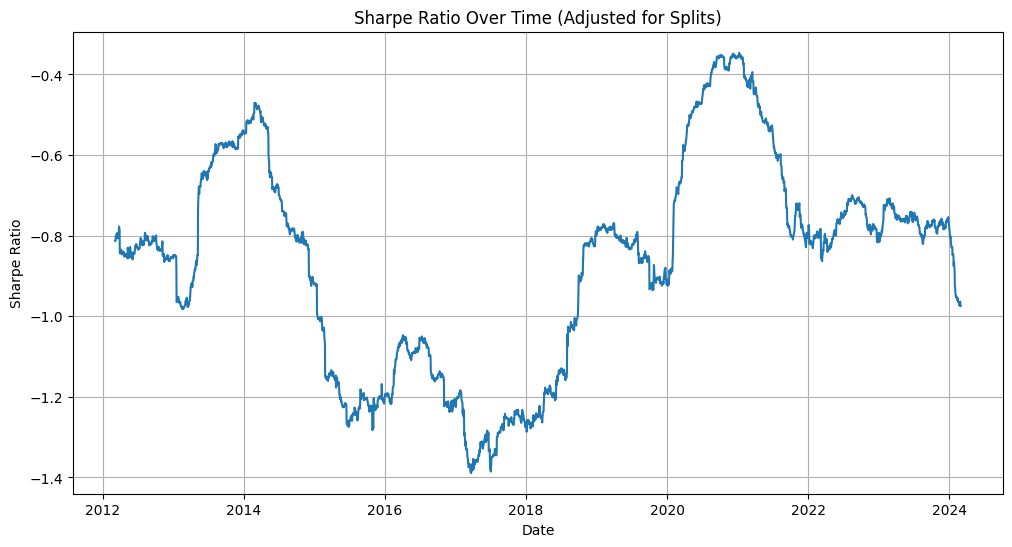

X_train shape: torch.Size([401, 5, 6])
y_train shape: torch.Size([401, 1])
X_test shape: torch.Size([101, 5, 6])
y_test shape: torch.Size([101, 1])


In [2]:
X_train, X_test, y_train, y_test, close_scaler = data()

Epoch [10/300], train_Loss: 0.12397543, test_Loss: 0.27290171, train_R2: -3.8726, test_R2: -11.6551
Epoch [20/300], train_Loss: 0.06007882, test_Loss: 0.18753573, train_R2: -1.3613, test_R2: -7.6965
Epoch [30/300], train_Loss: 0.03422648, test_Loss: 0.22874534, train_R2: -0.3452, test_R2: -9.6075
Epoch [40/300], train_Loss: 0.02030623, test_Loss: 0.22639544, train_R2: 0.2019, test_R2: -9.4985
Epoch [50/300], train_Loss: 0.00908628, test_Loss: 0.12468033, train_R2: 0.6429, test_R2: -4.7817
Epoch [60/300], train_Loss: 0.00310057, test_Loss: 0.06395758, train_R2: 0.8781, test_R2: -1.9659
Epoch [70/300], train_Loss: 0.00177075, test_Loss: 0.01282355, train_R2: 0.9304, test_R2: 0.4053
Epoch [80/300], train_Loss: 0.00171731, test_Loss: 0.00252886, train_R2: 0.9325, test_R2: 0.8827
Epoch [90/300], train_Loss: 0.00103767, test_Loss: 0.00234916, train_R2: 0.9592, test_R2: 0.8911
Epoch [100/300], train_Loss: 0.00096987, test_Loss: 0.00205164, train_R2: 0.9619, test_R2: 0.9049
Epoch [110/300], tr

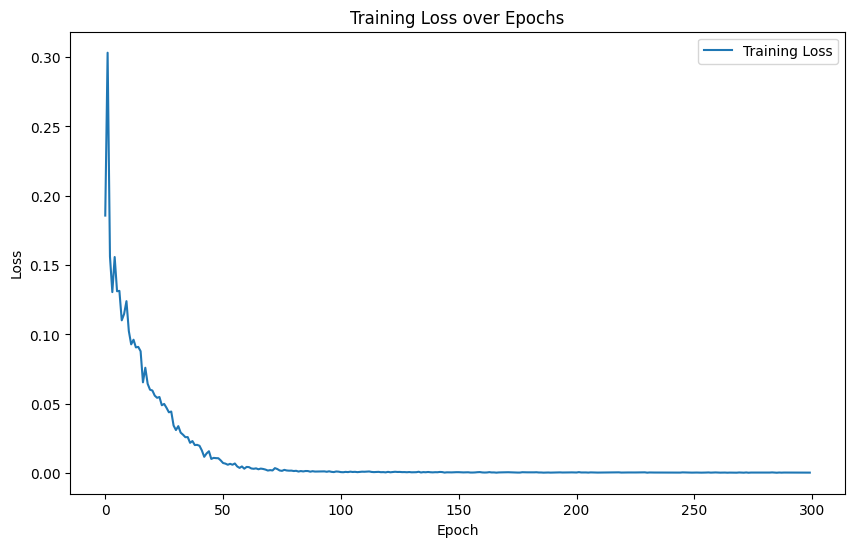

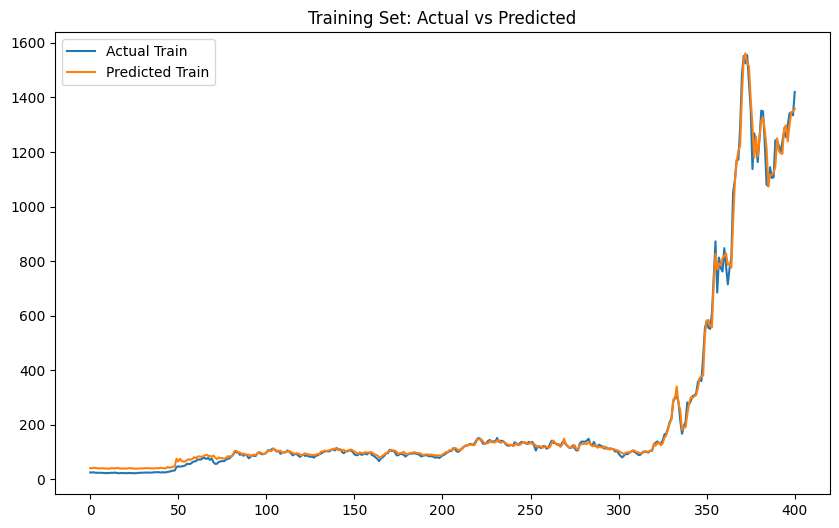

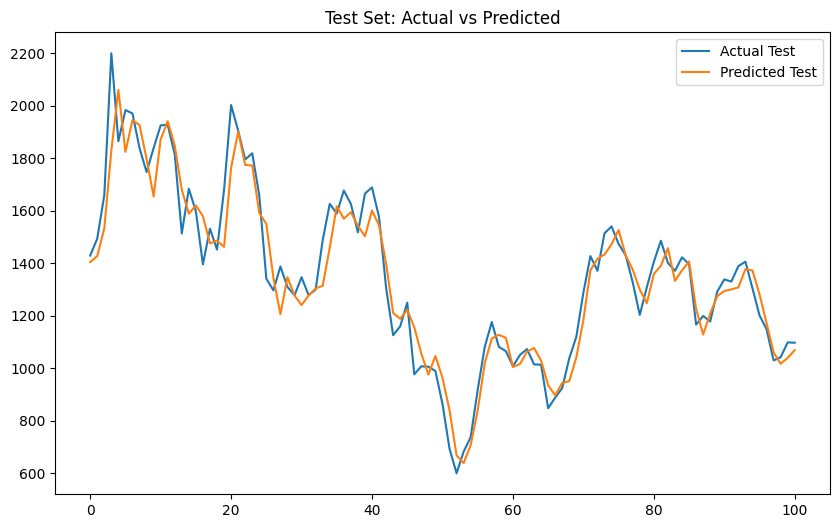

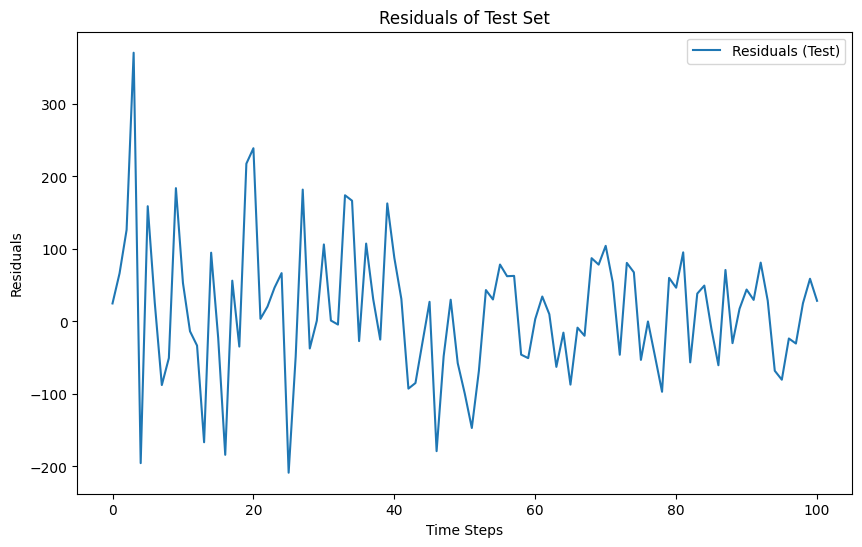

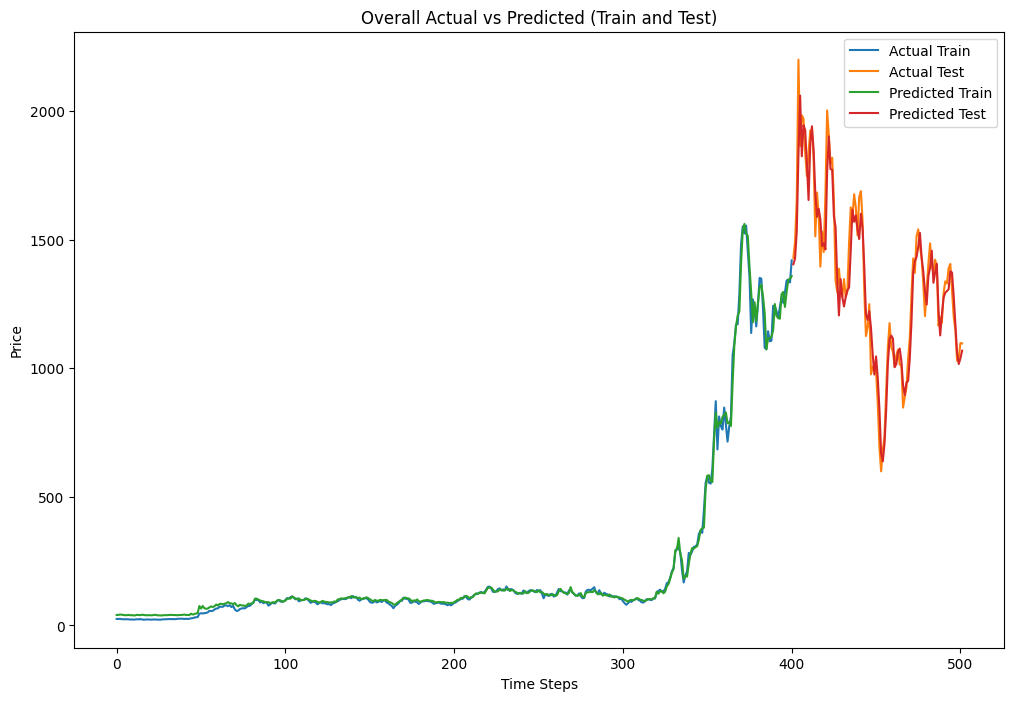

In [3]:
from LSTM_model import create_model, train_model, plot_losses, evaluate_model, plot_predictions, StockLSTM

file_path = 'TSLA.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])
data.set_index('Date', inplace=True)
    

def LSTM(X_train, X_test, y_train, y_test, scaler, input_dim):
    model = create_model(input_dim)
    model, losses,r2_train,r2_test = train_model(model, X_train, y_train, X_test,y_test)
    plot_losses(losses)
    
    # Return the model for subsequent evaluation
    return model,r2_train,r2_test

# Calling the main function
close_scaler = MinMaxScaler()
close_scaler.fit(data[['Close']])  

# Call the LSTM function and get the model
model,r2_train,r2_test_LSTM = LSTM(X_train, X_test, y_train, y_test, close_scaler, X_train.shape[2])


# Evaluate using the trained model
train_pred_scaled, test_pred_scaled, y_train_actual, y_test_actual = evaluate_model(model, X_train, X_test, y_train, y_test, close_scaler)
plot_predictions(y_train_actual, y_test_actual, train_pred_scaled, test_pred_scaled)



In [4]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Function for calculating evaluation metric
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Evaluate performance on the training set
mse_train, rmse_train, mae_train, r2_train = evaluate_model(y_train_actual, train_pred_scaled)
print(f'Training Set Performance:')
print(f'MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')

# Evaluate performance on the test set
mse_test, rmse_test, mae_test, r2_test = evaluate_model(y_test_actual, test_pred_scaled)
print(f'\nTest Set Performance:')
print(f'MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')


Training Set Performance:
MSE: 443.6019, RMSE: 21.0619, MAE: 11.9041, R²: 0.9965

Test Set Performance:
MSE: 8897.0850, RMSE: 94.3244, MAE: 71.0236, R²: 0.9160


Epoch [10/300], train_Loss: 0.01122902, test_Loss: 0.05572805, test_R2: -1.5842
Epoch [20/300], train_Loss: 0.00440109, test_Loss: 0.00700805, test_R2: 0.6750
Epoch [30/300], train_Loss: 0.00134964, test_Loss: 0.01044445, test_R2: 0.5157
Epoch [40/300], train_Loss: 0.00035303, test_Loss: 0.00151856, test_R2: 0.9296
Epoch [50/300], train_Loss: 0.00018589, test_Loss: 0.00232249, test_R2: 0.8923
Epoch [60/300], train_Loss: 0.00010917, test_Loss: 0.00169449, test_R2: 0.9214
Epoch [70/300], train_Loss: 0.00005031, test_Loss: 0.00124112, test_R2: 0.9424
Epoch [80/300], train_Loss: 0.00005424, test_Loss: 0.00126153, test_R2: 0.9415
Epoch [90/300], train_Loss: 0.00004933, test_Loss: 0.00122602, test_R2: 0.9431
Epoch [100/300], train_Loss: 0.00004831, test_Loss: 0.00122308, test_R2: 0.9433
Epoch [110/300], train_Loss: 0.00004696, test_Loss: 0.00121498, test_R2: 0.9437
Epoch [120/300], train_Loss: 0.00004651, test_Loss: 0.00120982, test_R2: 0.9439
Epoch [130/300], train_Loss: 0.00004602, test_Lo

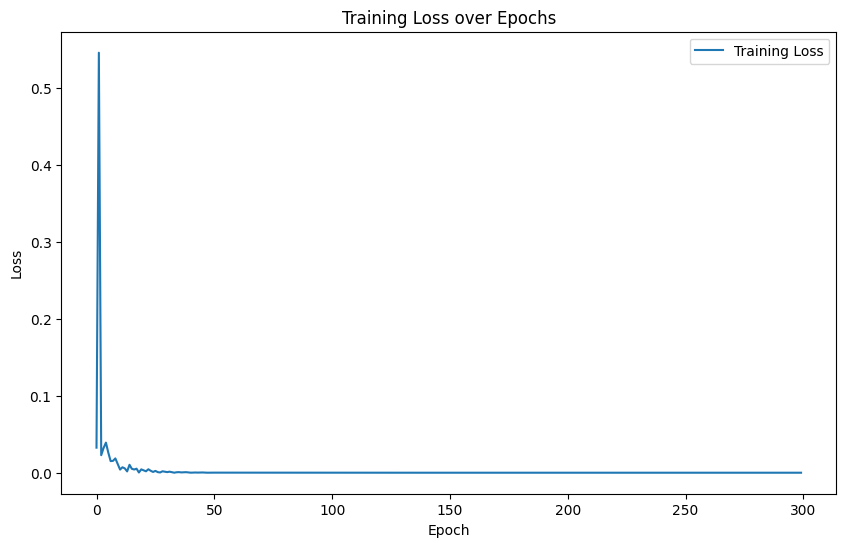

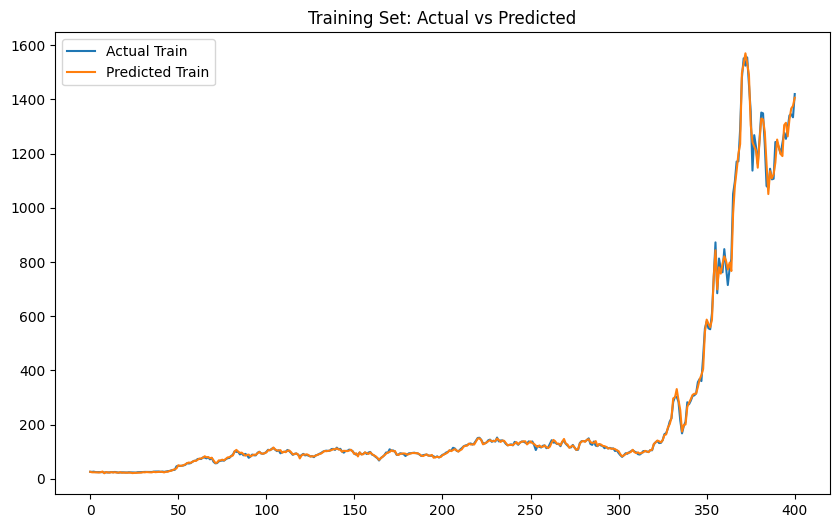

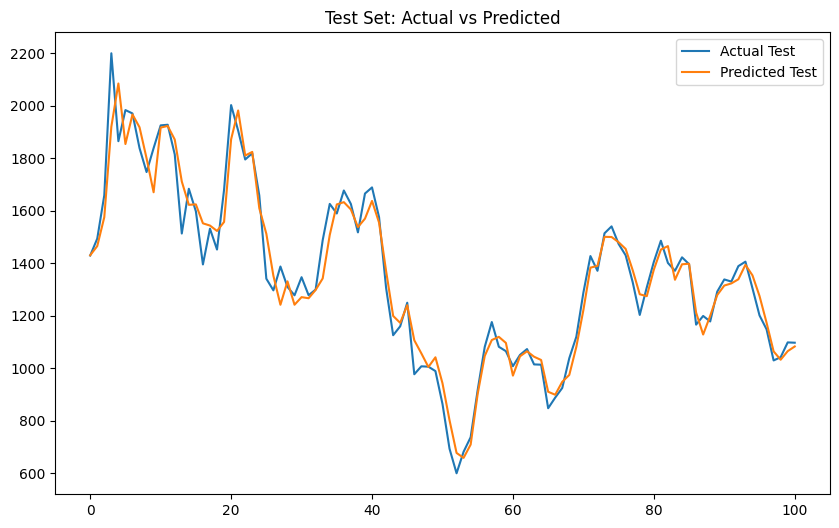

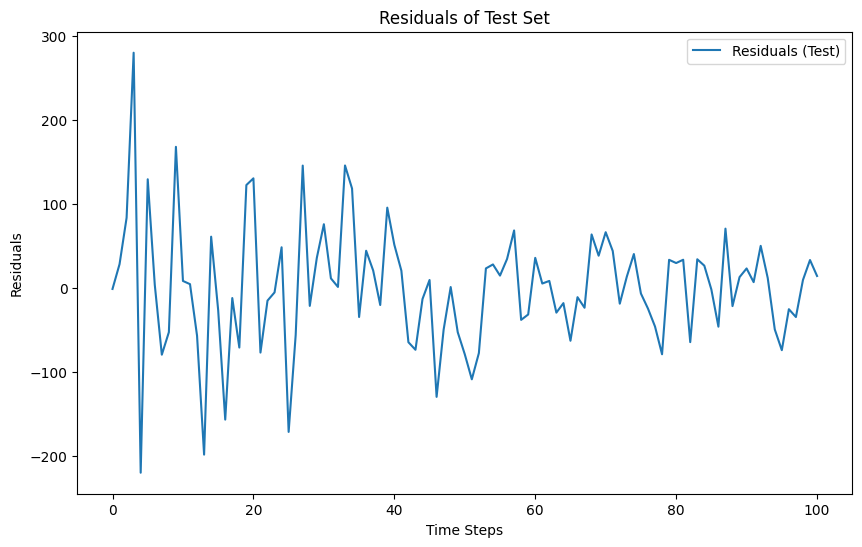

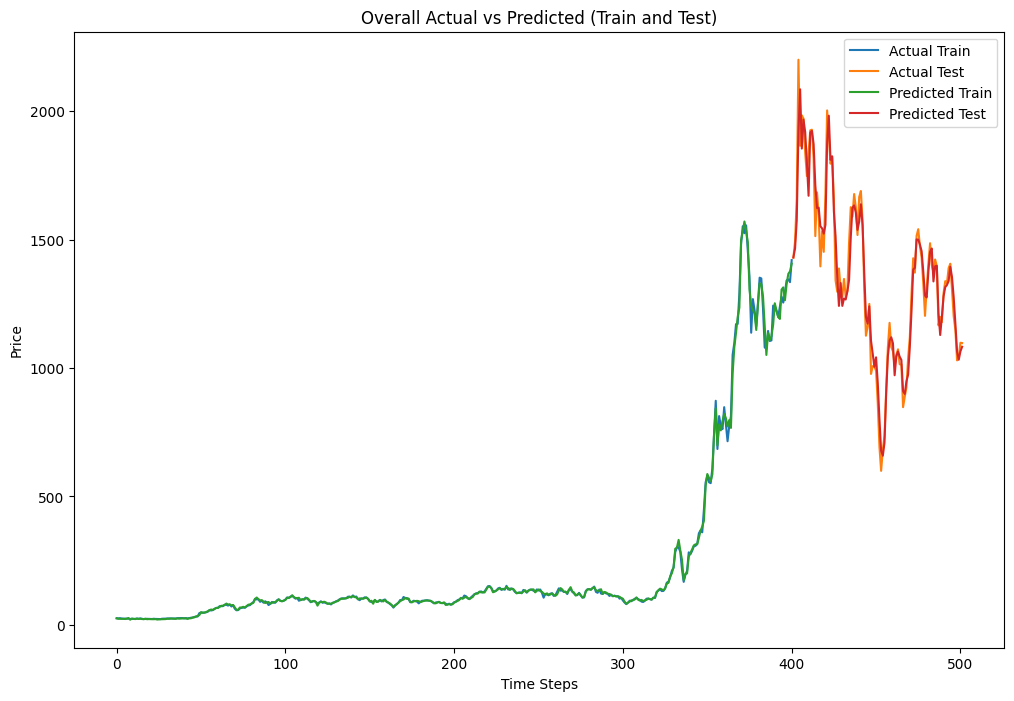

In [5]:

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from RNN_model import StockRNN, train_model, plot_losses, evaluate_model, plot_predictions, plot_residuals, plot_overall_comparison


input_dim = X_train.shape[2]
hidden_dim = 512
num_layers = 2
output_dim = 1
model = StockRNN(input_dim, hidden_dim, num_layers, output_dim)


losses,R2_test_RNN = train_model(model, X_train, y_train,X_test,y_test)
plot_losses(losses)


close_scaler = MinMaxScaler()
close_scaler.fit(data[['Close']])


y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled = evaluate_model(model, X_train, X_test, y_train, y_test, close_scaler)

# Plotting the predictions
plot_predictions(y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled)
plot_residuals(y_test_actual, test_pred_scaled)
plot_overall_comparison(y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled)


In [6]:

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2


mse_train, rmse_train, mae_train, r2_train = evaluate_model(y_train_actual, train_pred_scaled)
print(f'Training Set Performance:')
print(f'MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')


mse_test, rmse_test, mae_test, r2_test = evaluate_model(y_test_actual, test_pred_scaled)
print(f'\nTest Set Performance:')
print(f'MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Training Set Performance:
MSE: 196.0462, RMSE: 14.0017, MAE: 6.2884, R²: 0.9984

Test Set Performance:
MSE: 5407.5654, RMSE: 73.5361, MAE: 52.9844, R²: 0.9490


Epoch [10/300], train_Loss: 0.00184287, test_Loss: 0.00795321, test_R2: 0.6312
Epoch [20/300], train_Loss: 0.00027105, test_Loss: 0.00450782, test_R2: 0.7910
Epoch [30/300], train_Loss: 0.00012199, test_Loss: 0.00203695, test_R2: 0.9055
Epoch [40/300], train_Loss: 0.00010502, test_Loss: 0.00193644, test_R2: 0.9102
Epoch [50/300], train_Loss: 0.00008149, test_Loss: 0.00214626, test_R2: 0.9005
Epoch [60/300], train_Loss: 0.00007212, test_Loss: 0.00172291, test_R2: 0.9201
Epoch [70/300], train_Loss: 0.00006685, test_Loss: 0.00188161, test_R2: 0.9127
Epoch [80/300], train_Loss: 0.00006310, test_Loss: 0.00176052, test_R2: 0.9184
Epoch [90/300], train_Loss: 0.00006090, test_Loss: 0.00176758, test_R2: 0.9180
Epoch [100/300], train_Loss: 0.00005926, test_Loss: 0.00169893, test_R2: 0.9212
Epoch [110/300], train_Loss: 0.00005785, test_Loss: 0.00165063, test_R2: 0.9235
Epoch [120/300], train_Loss: 0.00005650, test_Loss: 0.00162219, test_R2: 0.9248
Epoch [130/300], train_Loss: 0.00005529, test_Los

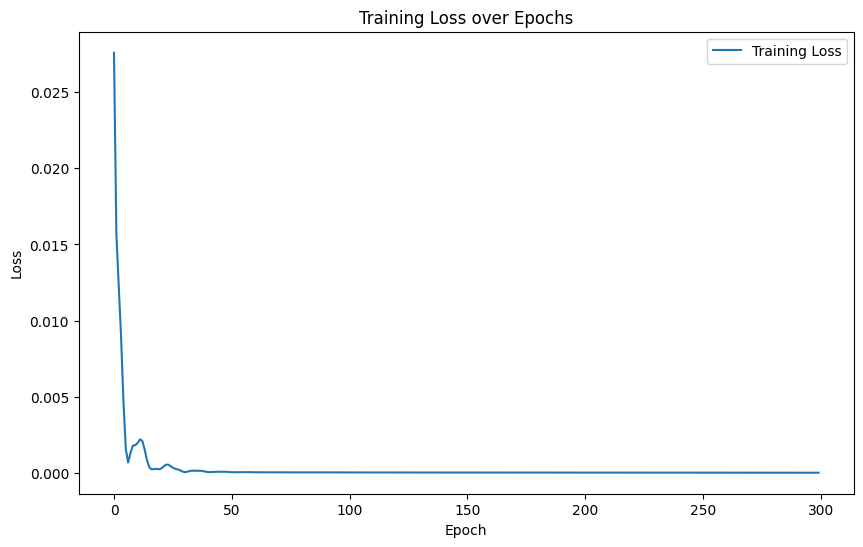

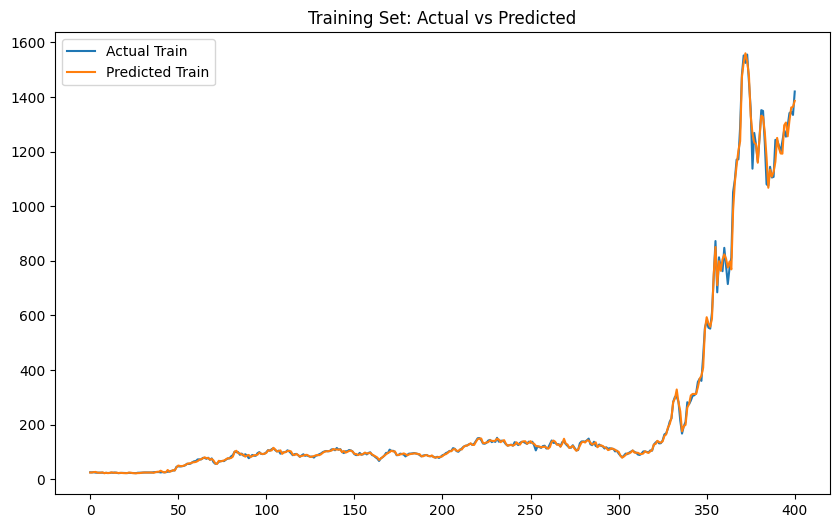

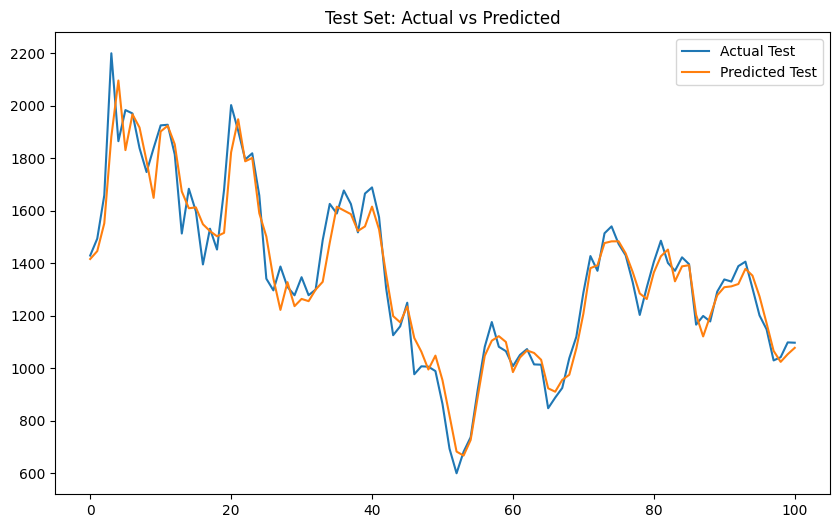

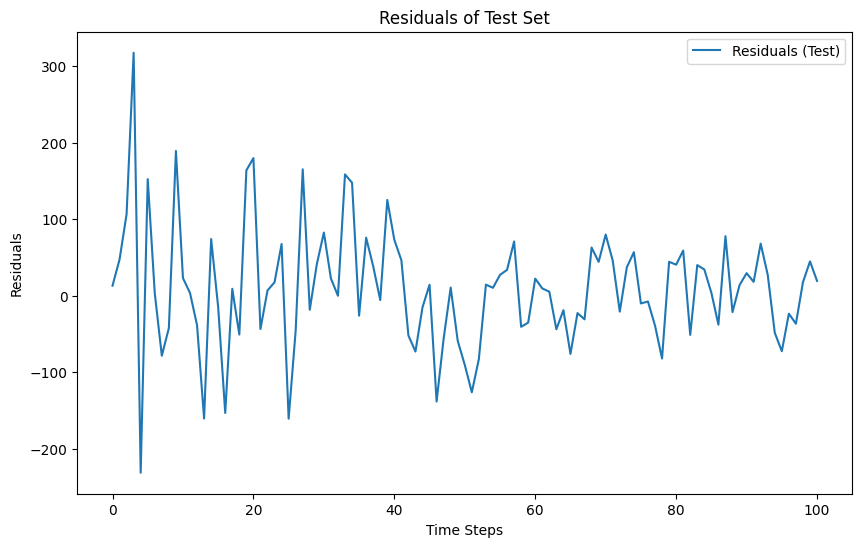

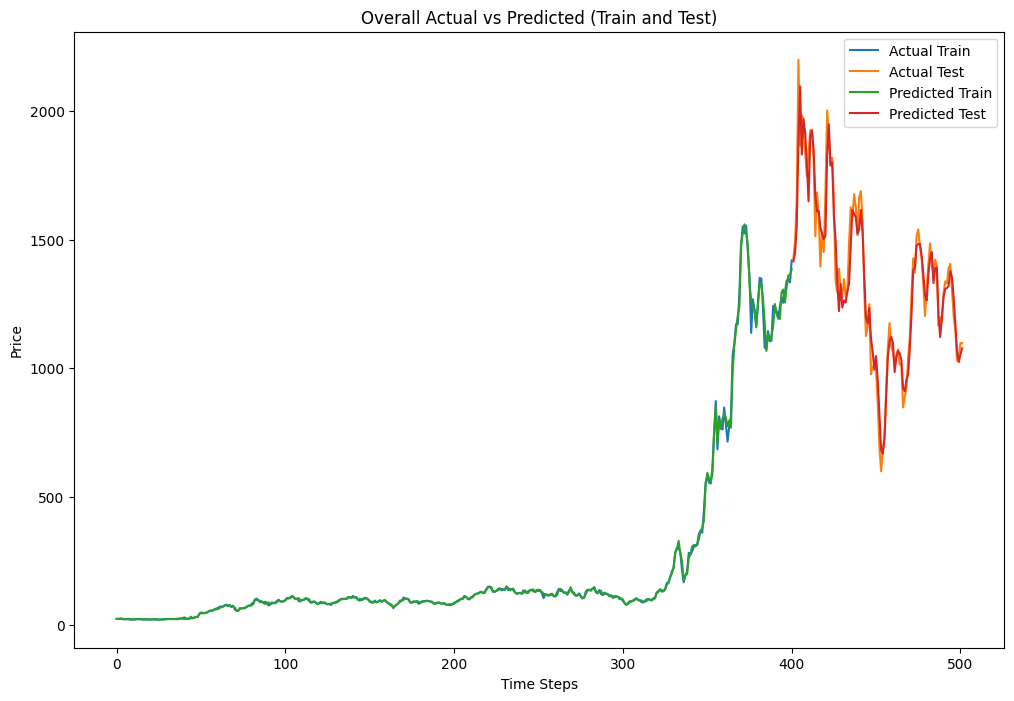

In [7]:

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from stock_mlp_model import StockMLP, train_model, plot_losses, evaluate_model, plot_predictions, plot_residuals, plot_overall_comparison


input_dim = X_train.shape[2] * X_train.shape[1]  # Flatten the input to (batch_size, time_steps * features)
hidden_dim = 256
num_layers = 2
output_dim = 1
model = StockMLP(input_dim, hidden_dim, num_layers, output_dim)


losses,r2_test_MLP = train_model(model, X_train, y_train,X_test,y_test)
plot_losses(losses)


close_scaler = MinMaxScaler()
close_scaler.fit(data[['Close']])


y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled = evaluate_model(model, X_train, X_test, y_train, y_test, close_scaler)


plot_predictions(y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled)
plot_residuals(y_test_actual, test_pred_scaled)
plot_overall_comparison(y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled)


In [8]:

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2


mse_train, rmse_train, mae_train, r2_train = evaluate_model(y_train_actual, train_pred_scaled)
print(f'Training Set Performance:')
print(f'MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')


mse_test, rmse_test, mae_test, r2_test = evaluate_model(y_test_actual, test_pred_scaled)
print(f'\nTest Set Performance:')
print(f'MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Training Set Performance:
MSE: 200.6113, RMSE: 14.1637, MAE: 6.2306, R²: 0.9984

Test Set Performance:
MSE: 6504.5630, RMSE: 80.6509, MAE: 58.6375, R²: 0.9386


Epoch [10/300], train_Loss: 0.00629480, test_Loss: 0.03936770, test_R2: -0.8256
Epoch [20/300], train_Loss: 0.00037174, test_Loss: 0.00186709, test_R2: 0.9134
Epoch [30/300], train_Loss: 0.00042716, test_Loss: 0.00222157, test_R2: 0.8970
Epoch [40/300], train_Loss: 0.00022213, test_Loss: 0.00196514, test_R2: 0.9089
Epoch [50/300], train_Loss: 0.00014407, test_Loss: 0.00182383, test_R2: 0.9154
Epoch [60/300], train_Loss: 0.00009280, test_Loss: 0.00162195, test_R2: 0.9248
Epoch [70/300], train_Loss: 0.00007437, test_Loss: 0.00155104, test_R2: 0.9281
Epoch [80/300], train_Loss: 0.00006498, test_Loss: 0.00143415, test_R2: 0.9335
Epoch [90/300], train_Loss: 0.00005986, test_Loss: 0.00140423, test_R2: 0.9349
Epoch [100/300], train_Loss: 0.00005691, test_Loss: 0.00134733, test_R2: 0.9375
Epoch [110/300], train_Loss: 0.00005465, test_Loss: 0.00132839, test_R2: 0.9384
Epoch [120/300], train_Loss: 0.00005292, test_Loss: 0.00132063, test_R2: 0.9388
Epoch [130/300], train_Loss: 0.00005167, test_Lo

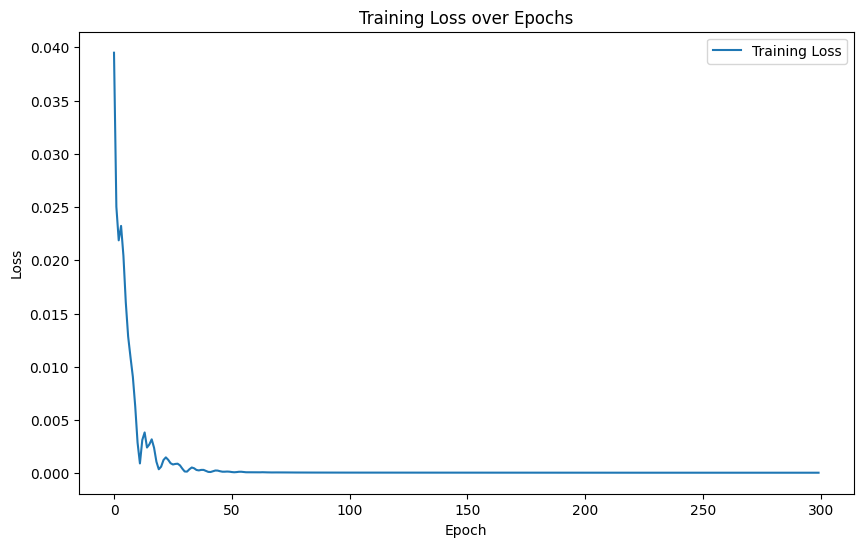

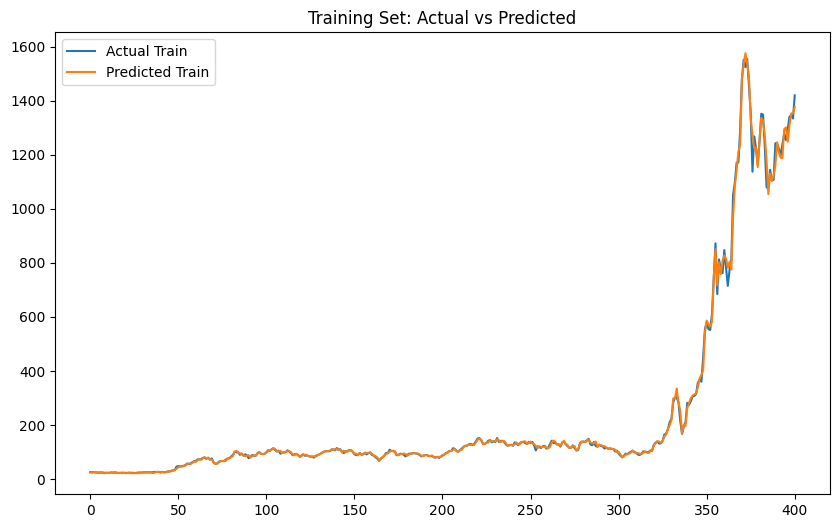

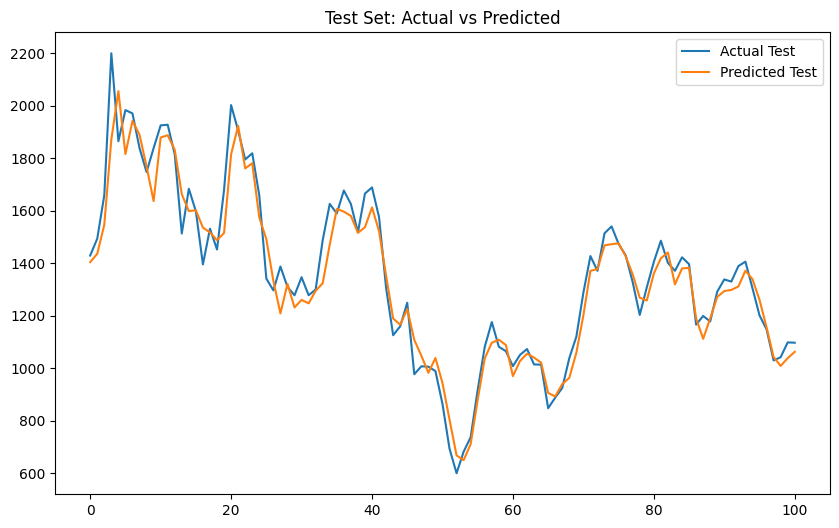

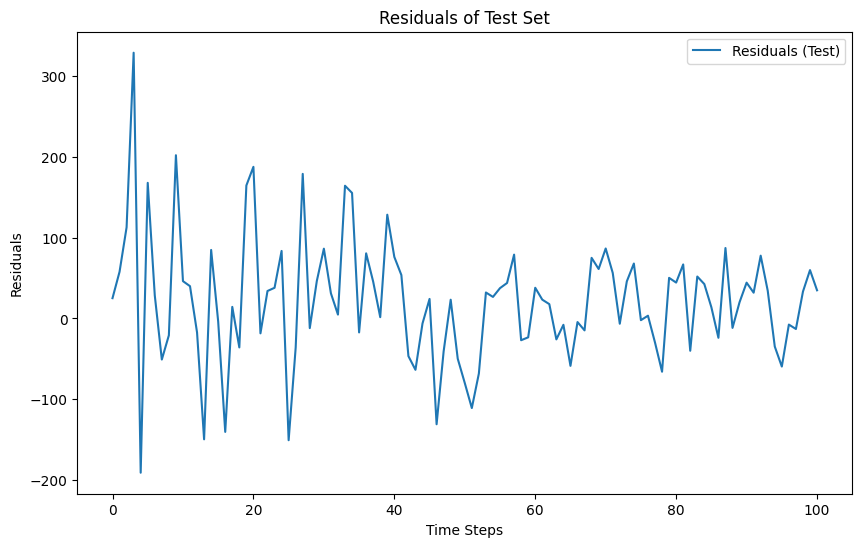

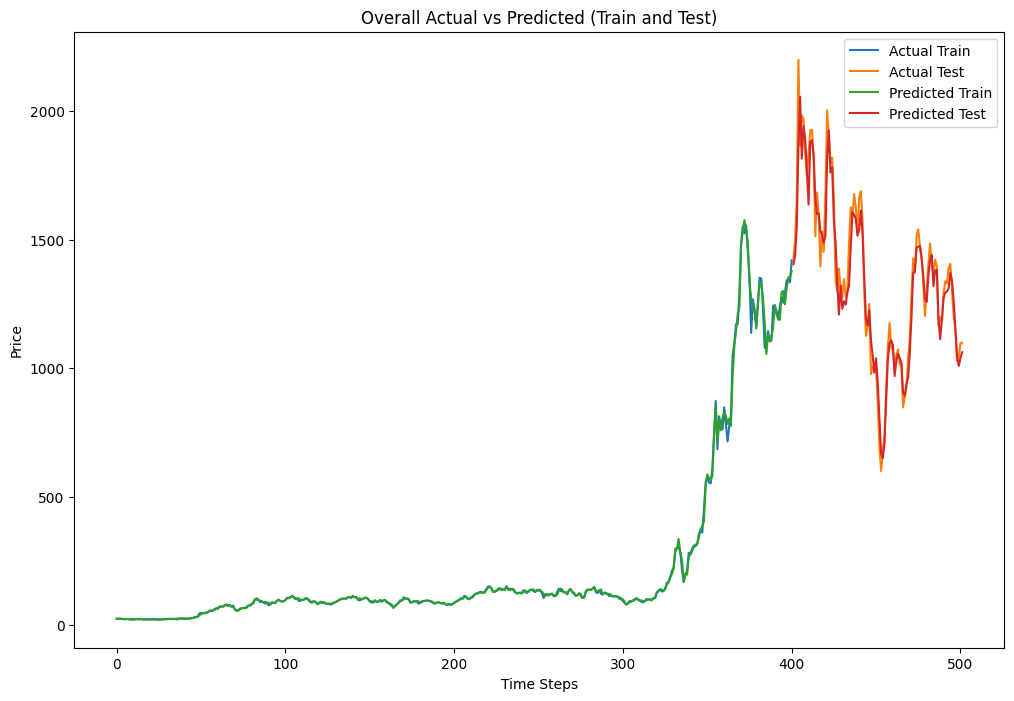

In [9]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from stock_bilstm_model import StockBiLSTM, train_model, plot_losses, evaluate_model, plot_predictions, plot_residuals, plot_overall_comparison


input_dim = X_train.shape[2]
hidden_dim = 256
num_layers = 2
output_dim = 1
model = StockBiLSTM(input_dim, hidden_dim, num_layers, output_dim)


losses,r2_test_bilstm = train_model(model, X_train, y_train,X_test,y_test)
plot_losses(losses)


close_scaler = MinMaxScaler()
close_scaler.fit(data[['Close']])


y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled = evaluate_model(model, X_train, X_test, y_train, y_test, close_scaler)


plot_predictions(y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled)
plot_residuals(y_test_actual, test_pred_scaled)
plot_overall_comparison(y_train_actual, train_pred_scaled, y_test_actual, test_pred_scaled)


In [10]:

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2


mse_train, rmse_train, mae_train, r2_train = evaluate_model(y_train_actual, train_pred_scaled)
print(f'Training Set Performance:')
print(f'MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}')


mse_test, rmse_test, mae_test, r2_test = evaluate_model(y_test_actual, test_pred_scaled)
print(f'\nTest Set Performance:')
print(f'MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}')

Training Set Performance:
MSE: 227.2208, RMSE: 15.0738, MAE: 6.4264, R²: 0.9982

Test Set Performance:
MSE: 6540.5332, RMSE: 80.8736, MAE: 59.3866, R²: 0.9383
